## 1. Load EBSD data

In [1]:
%matplotlib inline

# from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np

from orix import io, plot
from orix.crystal_map import Phase
# from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d
# from orix.crystal_map import CrystalMap, Phase, PhaseList
# from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import kikuchipy as kp
import os
from tqdm import tqdm
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_components, get_eds_average, coord_xmap_dict
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum, detect_anomalies_cnmf, plot_weight_map_cnmf
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca
from grid_search_component import optimize_paired_components, visualize_results
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
w, h = plt.rcParams["figure.figsize"]
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# data_path = "EBSD_scan"
# data_save = "save_map/"

data_path = "../EBSD_scan"

In [ ]:
fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)                                                                               

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [4]:
xmap
# eu1, eu2, eu3, x, y, iq, ci, phase_id, sem, Fit, bs, cs, ts, Oxygen, Mg, Al, Si, Ti, Mn, Fe  = np.loadtxt(fname_ang, unpack=True)

Phase   Orientations   Name  Space group  Point group  Proper point group       Color
    1       1 (0.0%)  Fe3O4         None          432                 432   tab:green
    2   1595 (62.7%)    FeO         None          432                 432  tab:orange
    3    946 (37.2%)     Fe         None          432                 432    tab:blue
Properties: unknown1, unknown2, unknown3, unknown4, unknown5, unknown6, unknown7, unknown8, unknown9, unknown10, unknown11, unknown12, unknown13, unknown14
Scan unit: um

In [5]:
edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)
s_edax

<EBSD, title: Scan3_cropped, dimensions: (62, 41|239, 239)>

### 1.1 Phase map/ IQ/ IPF/ CI MAP

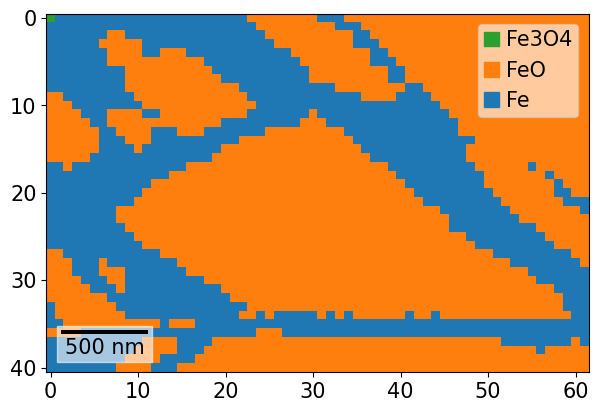

In [6]:
# phase map
xmap.plot()

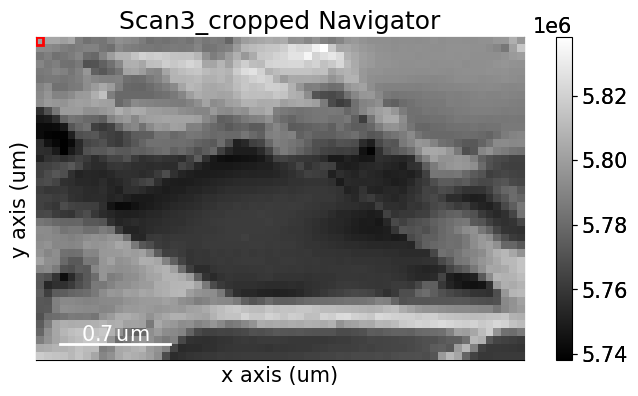

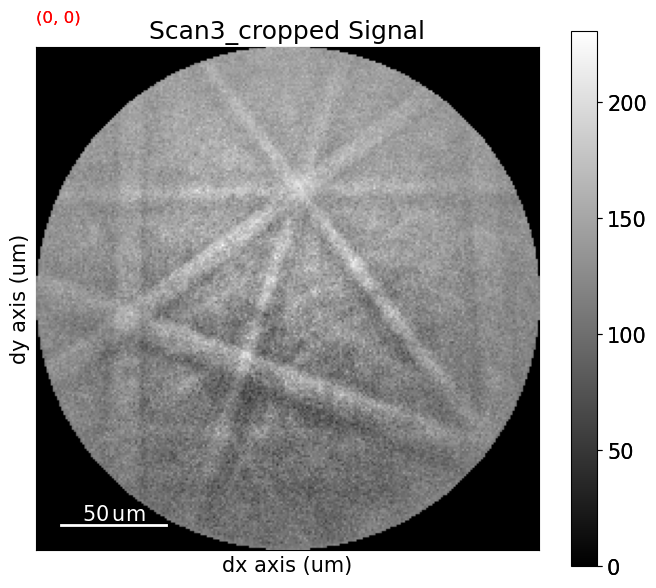

In [7]:
# Image quality map and kikuchi pattern

s_edax.plot()

In [8]:
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4         None          432                 432   tab:green
 2    FeO         None          432                 432  tab:orange
 3     Fe         None          432                 432    tab:blue

In [9]:
# set the space group number
# the crystal structure of iron would be changed based on the temperature and pressure
# α-Fe (Ferrite): Body-Centered Cubic (BCC)  Im-3m  (229); γ-Fe (Austenite): Face-Centered Cubic (FCC)  Fm-3m(225); δ-Fe; ε-Fe
xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [8]:
# rotations and orientation quaternions of different phases with respect of reference 
r = xmap.rotations

magnetite_ori = xmap["Fe3O4"].orientations
wustite_ori = xmap["FeO"].orientations
iron_ori = xmap["Fe"].orientations

Miller (12,), point group m-3m, hkil
[[ 0.  1. -1.  1.]
 [-1.  0.  1.  1.]
 [ 0. -1.  1.  1.]
 [ 1.  0. -1.  1.]
 [ 0. -1.  1. -1.]
 [ 1.  0. -1. -1.]
 [ 0.  1. -1. -1.]
 [-1.  0.  1. -1.]
 [ 1. -1. -0.  0.]
 [ 1.  1. -2.  0.]
 [-1.  1. -0.  0.]
 [-1. -1.  2.  0.]]
[########################################] | 100% Completed | 215.32 ms


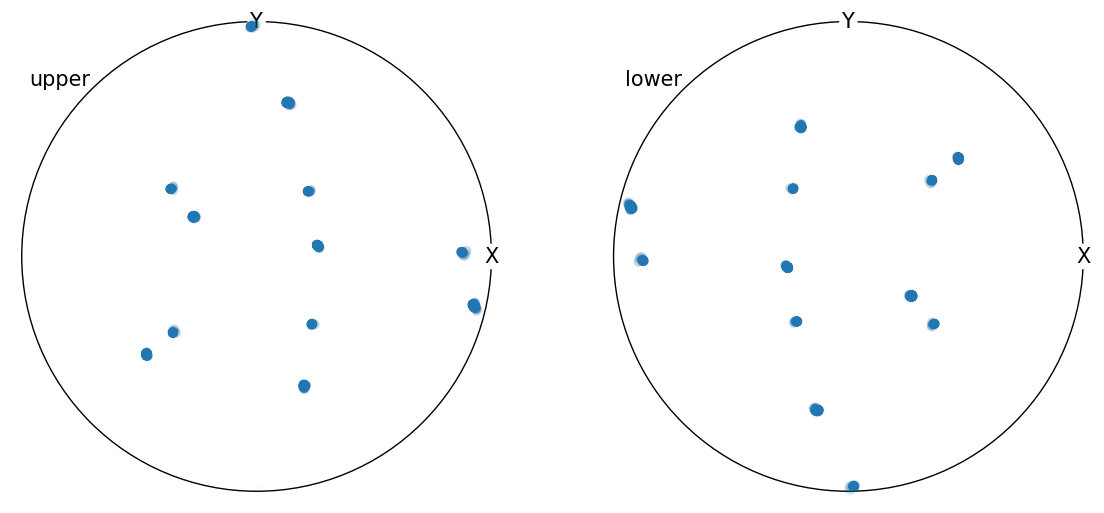

In [9]:
# define the crystal's point group and generate the set of symmetrically unique (011_1) 
g_wu = Miller(hkil=(0, 1, -1, 1), phase=Phase(point_group=wustite_ori.symmetry))
g_wu = g_wu.symmetrise(unique=True)
print(g_wu)
# compute the direction of poles in the sample reference frame
poles = wustite_ori.inv().outer(g_wu, lazy=True, progressbar=True, chunk_size=2000)

# plot the poles in the stereographic projection
poles.scatter(
    hemisphere="both",
    alpha=0.02,
    figure_kwargs={"figsize": (2 * h, h)},
    axes_labels=["X", "Y"],
)

Miller (12,), point group m-3m, hkil
[[ 0.  1. -1.  1.]
 [-1.  0.  1.  1.]
 [ 0. -1.  1.  1.]
 [ 1.  0. -1.  1.]
 [ 0. -1.  1. -1.]
 [ 1.  0. -1. -1.]
 [ 0.  1. -1. -1.]
 [-1.  0.  1. -1.]
 [ 1. -1. -0.  0.]
 [ 1.  1. -2.  0.]
 [-1.  1. -0.  0.]
 [-1. -1.  2.  0.]]
[########################################] | 100% Completed | 321.45 ms


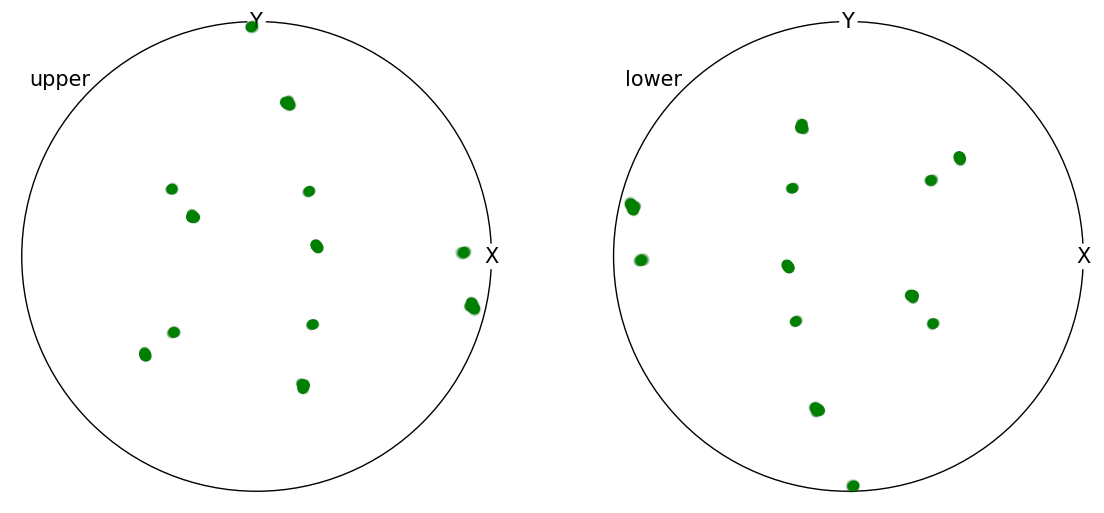

In [11]:
# define the crystal's point group and generate the set of symmetrically unique (011_1) 
g_ir = Miller(hkil=(0, 1, -1, 1), phase=Phase(point_group=iron_ori.symmetry))
g_ir = g_ir.symmetrise(unique=True)
print(g_ir)
# compute the direction of poles in the sample reference frame
poles = iron_ori.inv().outer(g_ir, lazy=True, progressbar=True, chunk_size=2000)

# plot the poles in the stereographic projection
poles.scatter(
    hemisphere="both",
    alpha=0.02,
    color= 'green',
    figure_kwargs={"figsize": (2 * h, h)},
    axes_labels=["X", "Y"],
)

In [10]:
# IPF from color key
ckey_m3m = plot.IPFColorKeyTSL(
    xmap.phases["FeO"].point_group, direction=Vector3d.zvector()
)
rgb_mag = ckey_m3m.orientation2color(xmap["Fe3O4"].orientations)
rgb_wus = ckey_m3m.orientation2color(xmap["FeO"].orientations)
rgb_iron = ckey_m3m.orientation2color(xmap["Fe"].orientations)

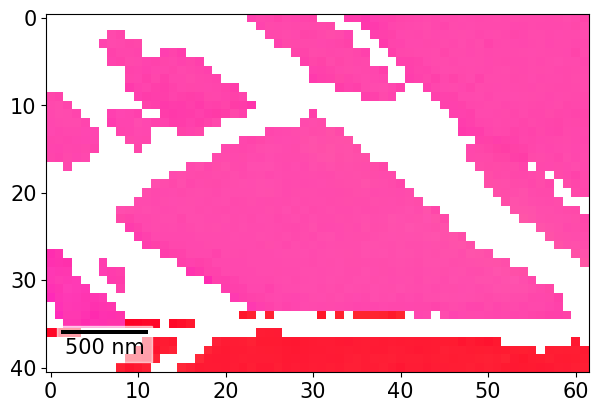

In [11]:
xmap["FeO"].plot(rgb_wus)

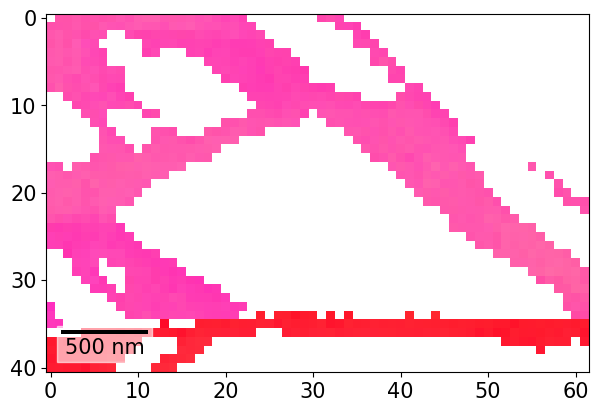

In [12]:
xmap["Fe"].plot(rgb_iron)

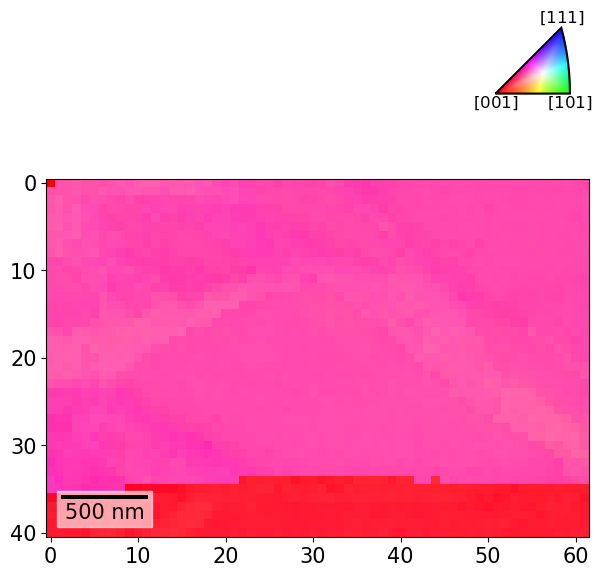

In [13]:
# IPF figure
rgb_all = np.zeros((xmap.size, 3))
rgb_all[xmap.phase_id == 1] = rgb_mag
rgb_all[xmap.phase_id == 2] = rgb_wus
rgb_all[xmap.phase_id == 3] = rgb_iron


fig = xmap.plot(rgb_all, return_figure=True)

rc = {"font.size": 8}
with plt.rc_context(rc):  # Temporarily reduce font size
    ax_ipfkey = fig.add_axes(
        [0.72, 0.87, 0.2, 0.1],
        projection="ipf",
        symmetry=xmap.phases["FeO"].point_group,
    )
    ax_ipfkey.plot_ipf_color_key()
    ax_ipfkey.set_title("")

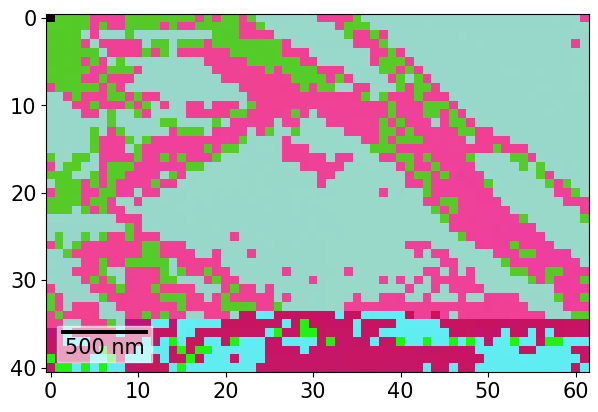

In [14]:
# plot IPF figure from euler angles (φ₁,Φ,φ₂) for rgb values
ckey_euler = plot.EulerColorKey(xmap.phases["FeO"].point_group)
rgb_mag_euler = ckey_euler.orientation2color(xmap["Fe3O4"].orientations)
rgb_wus_euler = ckey_euler.orientation2color(xmap["FeO"].orientations)
rgb_iron_euler = ckey_euler.orientation2color(xmap["Fe"].orientations)


rgb_all_euler = np.zeros((xmap.size, 3))
rgb_all_euler[xmap.phase_id == 1] = rgb_mag_euler
rgb_all_euler[xmap.phase_id == 2] = rgb_wus_euler
rgb_all_euler[xmap.phase_id == 3] = rgb_iron_euler


ipf_euler_fig = xmap.plot(rgb_all_euler,return_figure=True)

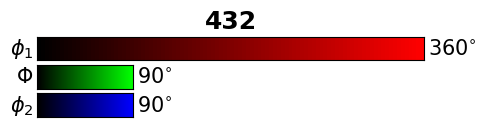

In [15]:
ckey_euler.plot()

In [11]:
# xmap parameters: IQ, CI, sem, fit, bs, cs, ts, oxygen, Mg, Al, Si, Ti, Mn, Fe
xmap.prop


# xmap.prop["iq"] = xmap.prop.pop("unknown1")
# xmap.prop["ci"] = xmap.prop.pop("unknown2")
# xmap.prop["sem"] = xmap.prop.pop("unknown3")
# xmap.prop["fit"] = xmap.prop.pop("unknown4")
# xmap.prop["bs"] = xmap.prop.pop("unknown5")
# xmap.prop["cs"] = xmap.prop.pop("unknown6")
# xmap.prop["ts"] = xmap.prop.pop("unknown7")
# xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
# xmap.prop["Mg"] = xmap.prop.pop("unknown9")
# xmap.prop["Al"] = xmap.prop.pop("unknown10")
# xmap.prop["Si"] = xmap.prop.pop("unknown11")
# xmap.prop["Ti"] = xmap.prop.pop("unknown12")
# xmap.prop["Mn"] = xmap.prop.pop("unknown13")
# xmap.prop["Fe"] = xmap.prop.pop("unknown14")

{'iq': array([0.00000000e+00, 9.64227904e+08, 9.94274304e+08, ...,
        1.26061517e+09, 1.28017229e+09, 1.28190464e+09]),
 'ci': array([0.   , 0.364, 0.241, ..., 0.173, 0.291, 0.291]),
 'sem': array([13840., 13971., 13657., ..., 11867., 12197., 12209.]),
 'fit': array([1.698, 1.872, 1.85 , ..., 1.528, 1.381, 1.4  ]),
 'bs': array([202.768204, 203.100693, 202.624207, ..., 199.769394, 199.568802,
          0.      ]),
 'cs': array([2267.427979, 2271.670898, 2283.7771  , ..., 2210.727051,
        2210.87793 ,    0.      ]),
 'ts': array([319.267609, 319.920807, 320.177887, ..., 299.134186, 299.243195,
          0.      ]),
 'oxygen': array([ 931.,  942., 1004., ..., 1071., 1041., 1022.]),
 'Mg': array([55., 60., 51., ..., 45., 32., 49.]),
 'Al': array([50., 51., 58., ..., 38., 42., 35.]),
 'Si': array([46., 61., 56., ..., 58., 50., 52.]),
 'Ti': array([17., 10., 27., ..., 21., 13., 16.]),
 'Mn': array([19., 12., 14., ..., 18., 24., 15.]),
 'Fe': array([429., 469., 477., ..., 460., 434.

In [10]:
xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

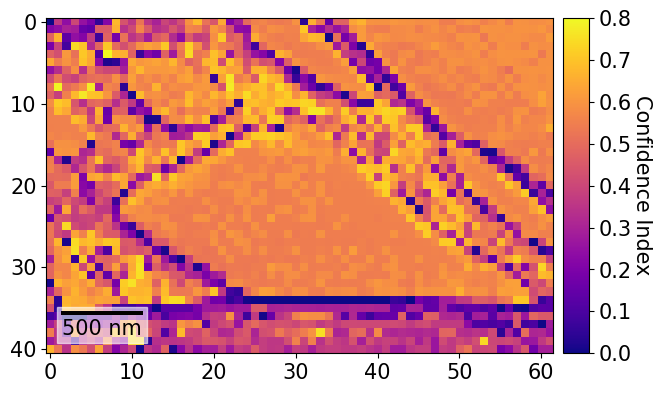

In [93]:
# Confidence index map
fig = xmap.plot(
    xmap.ci,
    cmap="plasma",
    colorbar=True,
    colorbar_label="Confidence Index",
    return_figure=True,
    )

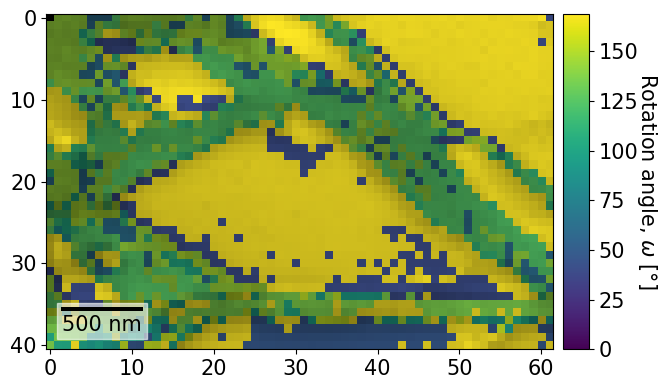

In [94]:
# Get rotation angles in degrees
angles = xmap.rotations.angle * 180 / np.pi

xmap.plot(
    angles,
    vmax=angles.max()-10,
    overlay=xmap.iq,
    colorbar=True,
    colorbar_label=r"Rotation angle, $\omega$ [$\degree$]",
)

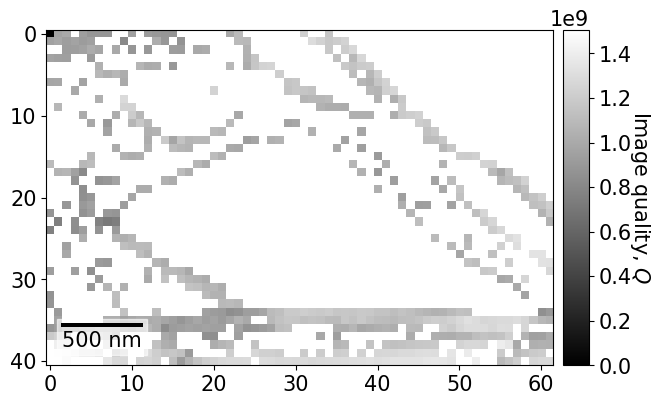

In [31]:
# Conditional slicing：plot the ci value < 0.4 -> boundary
xmap[xmap.ci < 0.4].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

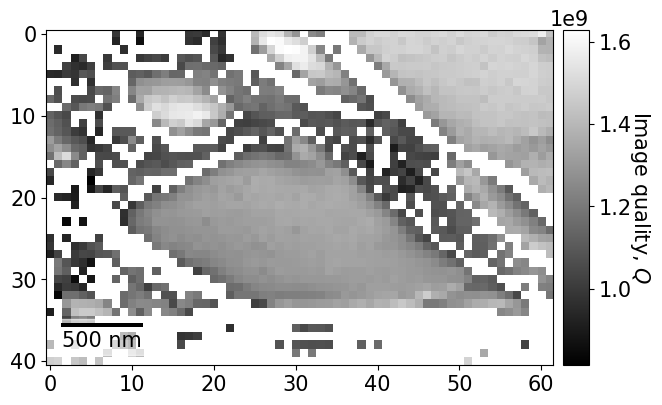

In [ ]:
xmap[xmap.ci > 0.5].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

In [11]:
print("The ci value > 0.7, x = ", xmap[xmap.ci > 0.7].x/0.05)
print("The ci value > 0.7, y = ", xmap[xmap.ci > 0.7].y/0.05)

The ci value > 0.7, x =  [31. 21.  3.  7. 14. 17.  4.  7. 17. 22. 26.  1.  5. 22. 28. 39.  4. 22.
 24. 29.  1. 28. 30. 31. 32. 40. 24. 27. 32. 33. 36. 40. 41. 42. 43. 27.
 28. 39. 41. 42. 22. 44. 45. 18. 19. 25. 26. 27. 45. 16. 19. 23. 24. 11.
 16. 42. 38. 41. 13. 15. 39. 55. 40. 41. 51. 56. 41. 47. 58.  2. 45. 46.
 48.  5. 46.  3.  7. 48. 49.  3.  4. 11. 57. 11. 60. 11.  9. 10.  9. 20.
 14. 15. 16. 57. 58. 10. 33. 10. 11. 53.]
The ci value > 0.7, y =  [ 1.  2.  3.  3.  3.  3.  4.  4.  4.  7.  7.  8.  8.  8.  8.  8.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12.
 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 16.
 16. 16. 18. 18. 19. 19. 19. 19. 20. 20. 20. 20. 21. 21. 21. 25. 25. 25.
 25. 26. 26. 27. 27. 27. 27. 28. 29. 29. 29. 30. 30. 31. 32. 32. 33. 33.
 34. 34. 34. 34. 34. 38. 38. 39. 39. 39.]


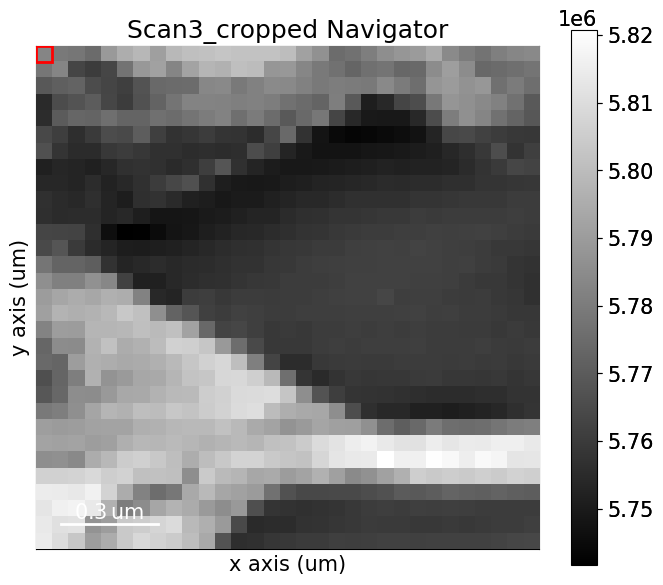

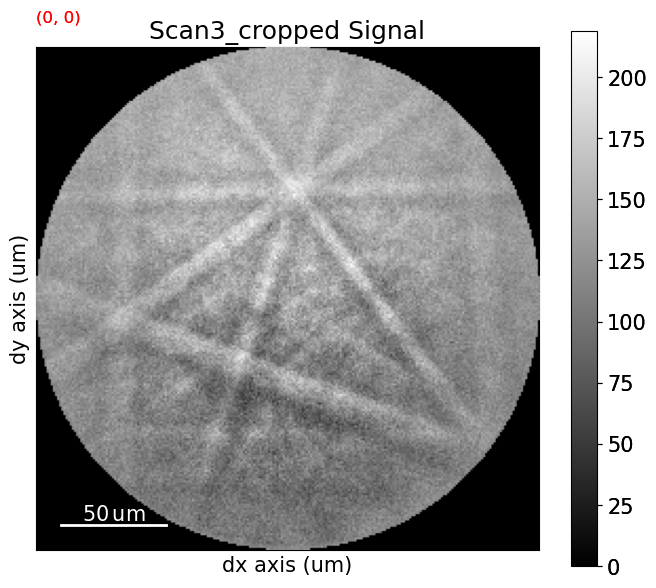

In [12]:
s_edax.inav[5:36,10:41].plot()

In [12]:
s_edax.xmap = xmap
s_edax.xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [90]:
output_dir = "EBSD_scan"
os.makedirs(output_dir, exist_ok=True)  # Create the folder if not existed

# Gain the navigation shape
n_rows, n_cols = s_edax.axes_manager.navigation_shape
print(n_rows, n_cols)
# iterate all the scan points and display the progress
for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        # Obtain the data at [i,j]
        # print(i,j)
        pattern = s_edax.inav[i, j].data

        # Preprocessing normalization?
        # pattern_normalized = (pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255
        # pattern_normalized = pattern_normalized.astype(np.uint8)

        # Define the name of output pictures
        filename = os.path.join(output_dir, f"scan3_x_{i}_y_{j}.jpg")

        # save as jpg(grey figure)
        plt.imsave(filename, pattern, cmap="gray", vmin=pattern.min(), vmax=pattern.max())

62 41


100%|██████████| 62/62 [01:00<00:00,  1.03it/s]


## 1.2 Select initial components

x dimensions 62 
 y dimensions 41 
 in multiples of 1


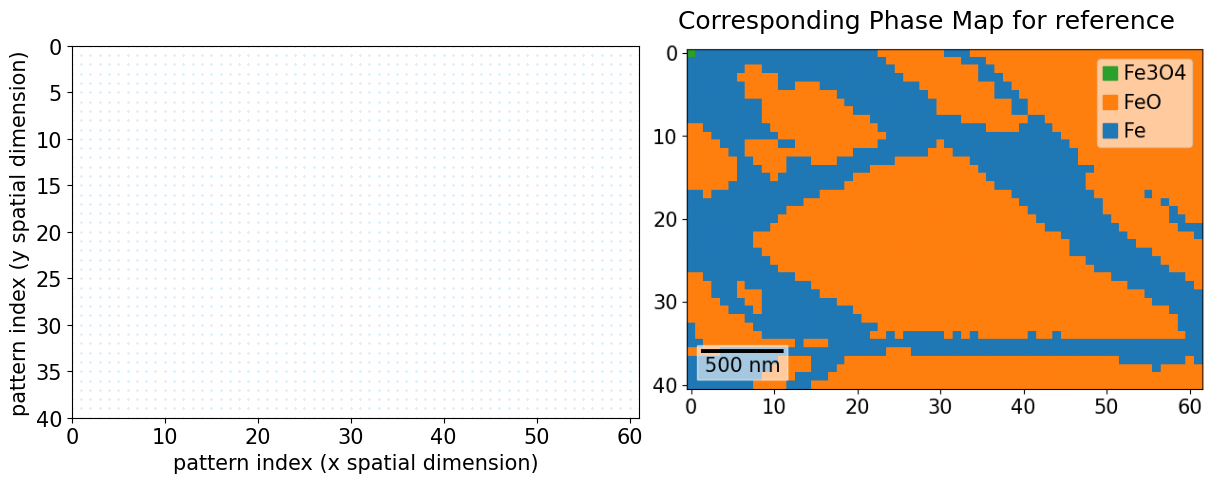

In [13]:
path = "../EBSD_scan/"
grid = read_data(path)

In [14]:
x_range_r1, y_range_r1, x_range_r2, y_range_r2= (30,35), (25,30), (40,45), (12,17)
# s_edax.inav[30:37,25:32].xmap.plot()

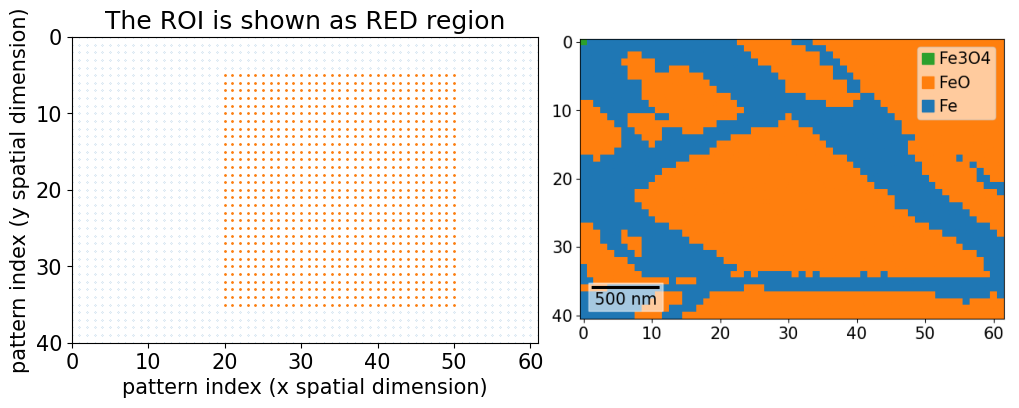

In [15]:
# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)

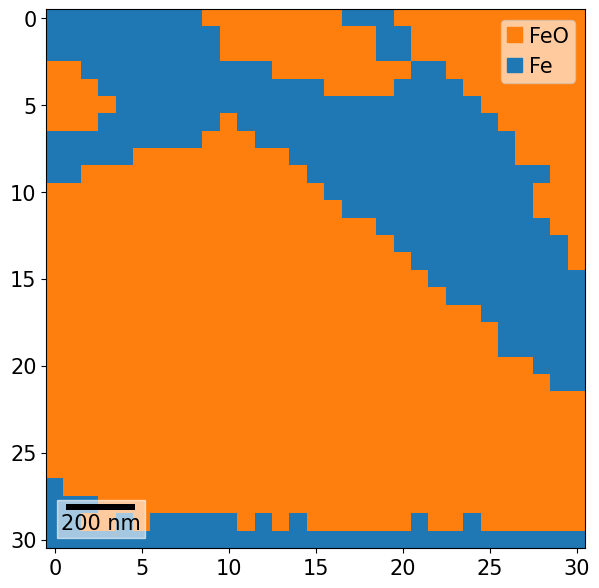

In [25]:
s_edax.inav[20:51,5:36].xmap.plot()

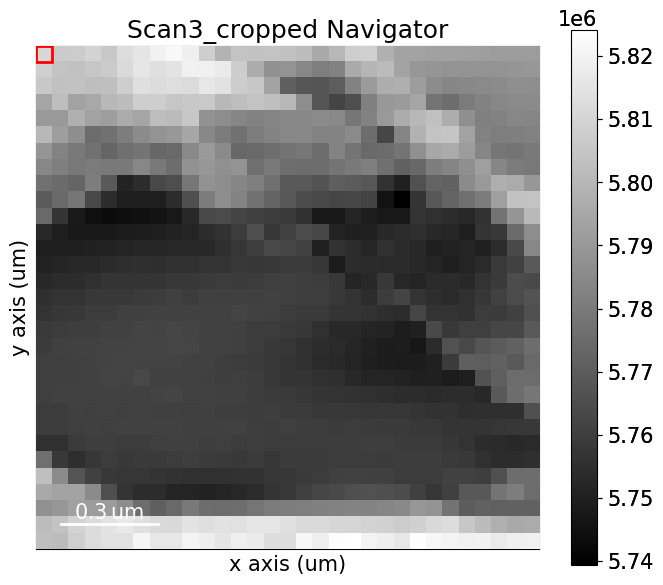

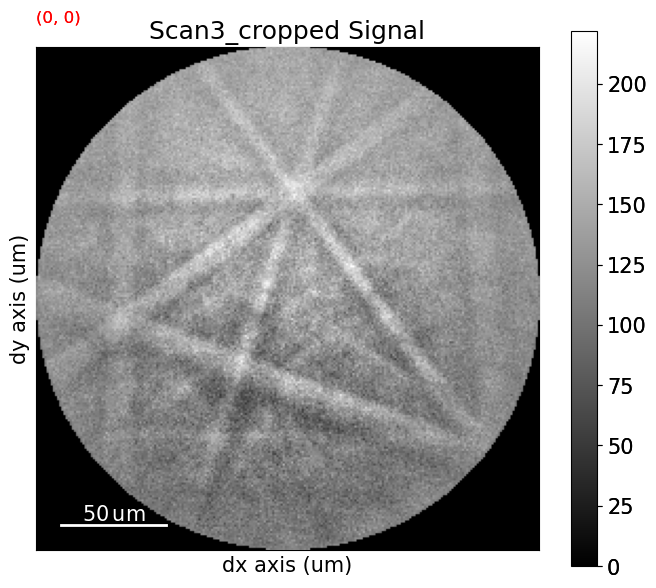

In [26]:
# ROI Image quality map
s_edax.inav[20:51,5:36].plot()

# s_edax.inav[40:42,27:29].plot()
# s_edax.inav[44:46,12:14].plot()

### 1.3 PCA

In [16]:
# dict {x,y} coordinates: phase index
coor_dict = coord_xmap_dict(s_edax.xmap,0.05)

In [21]:
# weights for each component
pca_scores = run_PCA(R6,2)

[########################################] | 100% Completed | 111.20 ms
[########################################] | 100% Completed | 107.21 ms
[########################################] | 100% Completed | 120.25 ms
[########################################] | 100% Completed | 112.43 ms
[########################################] | 100% Completed | 111.98 ms
[########################################] | 100% Completed | 112.39 ms
[########################################] | 100% Completed | 106.29 ms
[########################################] | 100% Completed | 109.97 ms
[########################################] | 100% Completed | 119.10 ms
[########################################] | 100% Completed | 118.13 ms
[########################################] | 100% Completed | 120.23 ms
[########################################] | 100% Completed | 120.60 ms
[########################################] | 100% Completed | 120.88 ms
[########################################] | 100% Completed | 11

In [22]:
# obtain the anomalies
anomalies_scores, anomalies_coords = detect_anomalies_pca(pca_scores,coor_dict,loc)

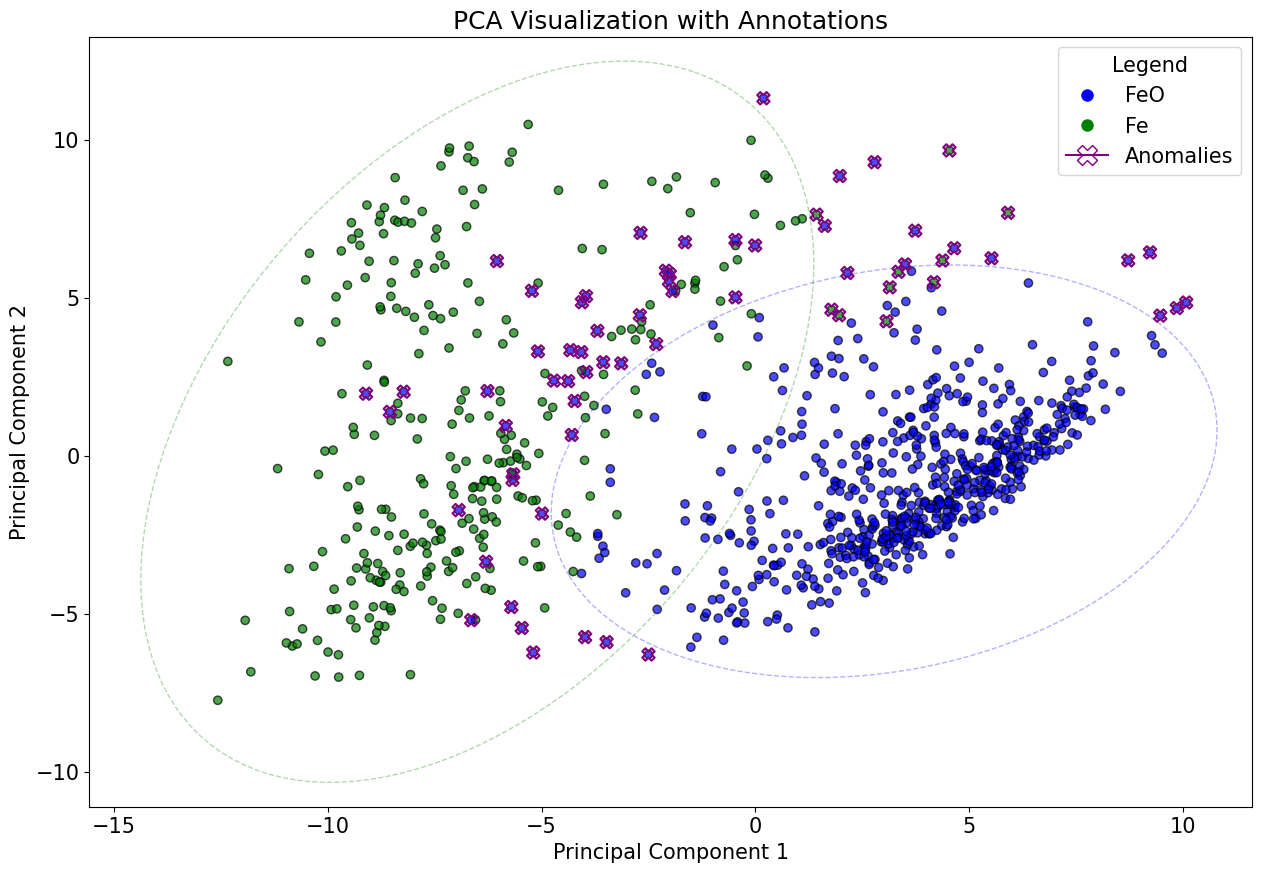

In [23]:
# plot pca weight for points within roi
# _plot_pca(pca_scores, coor_dict, loc)
_plot_pca(pca_scores, coor_dict, loc, None, None, anomalies_scores, ellipse_alpha=0.3)

(961, 2)


(-0.5, 30.5, 30.5, -0.5)

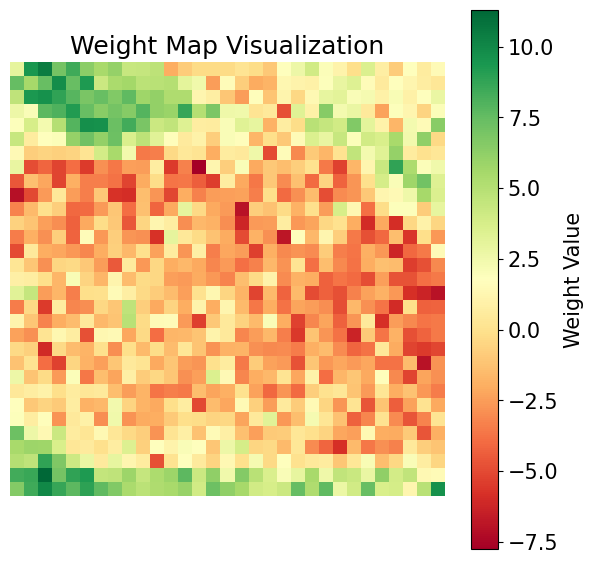

In [18]:
# visualize weight map of pca
print(np.shape(pca_scores))
weight_map = np.reshape(pca_scores, (31, 31, 2)) 
im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value') 
plt.title("Weight Map Visualization")
plt.axis('off')  

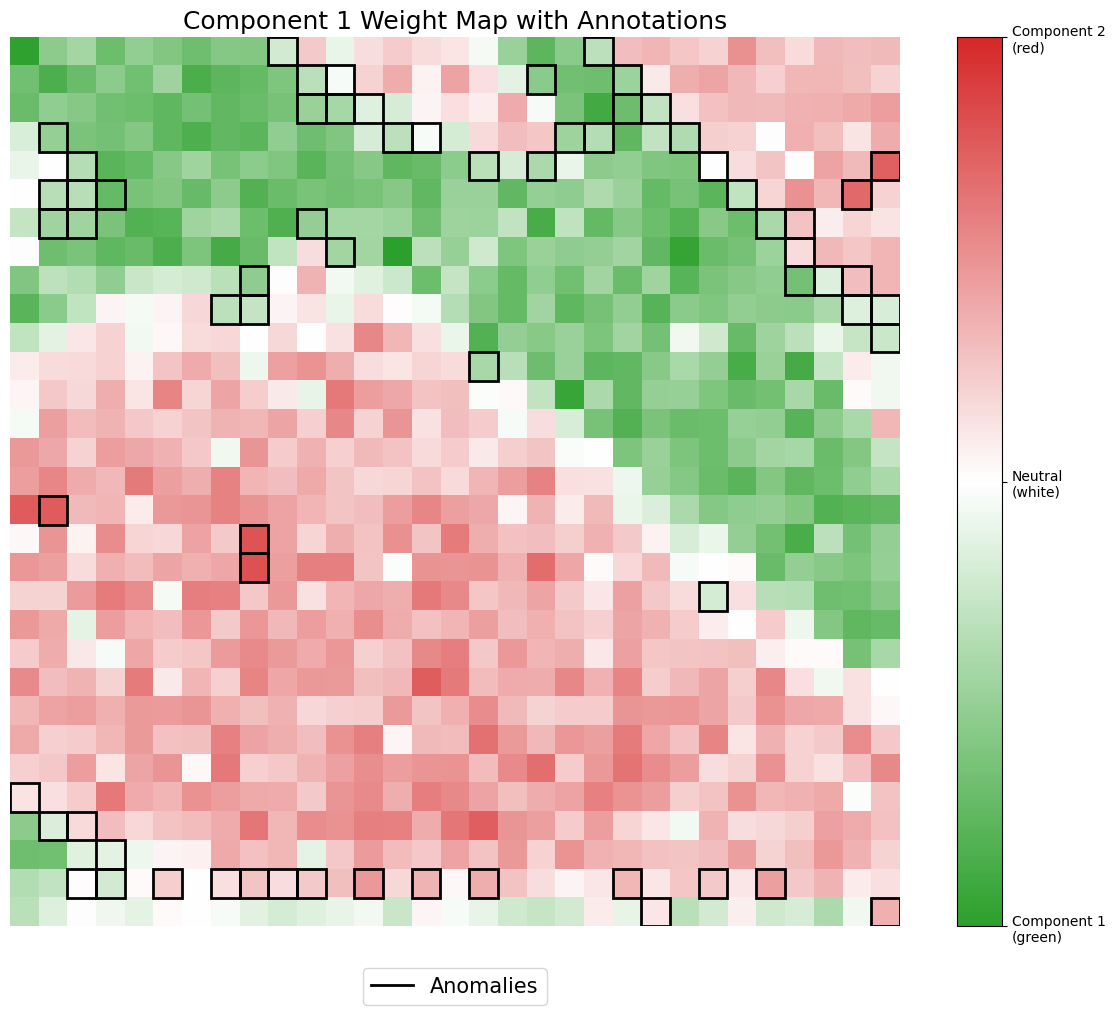

In [24]:
plot_weight_map_pca(pca_scores,loc,anomalies_coords,None,None,0)

### 1.4 cNMF

In [16]:
x_range_r1,y_range_r1

((30, 35), (25, 30))

In [17]:
optimize_results= optimize_paired_components(R6, path, grid, x_range_r1, y_range_r1, x_range_r2, y_range_r2, 2, 2, 3)

[((30, 32), (25, 27)), ((30, 32), (27, 29)), ((32, 34), (25, 27)), ((32, 34), (27, 29))]


Optimizing paired components:   0%|          | 0/16 [00:00<?, ?it/s]

The number of component pair candidate: 16
(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 112.43 ms
[########################################] | 100% Completed | 108.00 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 108.05 ms
[########################################] | 100% Completed | 112.49 ms
[########################################] | 100% Completed | 109.09 ms
[########################################] | 100% Completed | 106.74 ms
[########################################] | 100% Completed | 106.23 ms
[########################################] | 100% Completed | 107.80 ms
[########################################] | 100% Completed | 113.95 ms
[########################################] | 100% Completed | 105.86 ms
[########################################] | 100% Completed | 117.60 ms
[########################################] | 100% Completed | 109.97 ms
[#######

Optimizing paired components:   6%|▋         | 1/16 [1:42:18<25:34:43, 6138.92s/it, current_mse=1.54e-5, current_r2=0.672]

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 109.78 ms
[########################################] | 100% Completed | 107.87 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.04 ms
[########################################] | 100% Completed | 109.02 ms
[########################################] | 100% Completed | 108.01 ms
[########################################] | 100% Completed | 105.38 ms
[########################################] | 100% Completed | 105.72 ms
[########################################] | 100% Completed | 104.98 ms
[########################################] | 100% Completed | 105.29 ms
[########################################] | 100% Completed | 106.85 ms
[########################################] | 100% Completed | 106.31 ms
[########################################] | 100% Completed | 105.39 ms
[########################################] | 100% C

Optimizing paired components:  12%|█▎        | 2/16 [1:48:33<10:41:11, 2747.98s/it, current_mse=2.32e-5, current_r2=0.665]

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 117.04 ms
[########################################] | 100% Completed | 107.02 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.07 ms
[########################################] | 100% Completed | 107.22 ms
[########################################] | 100% Completed | 107.16 ms
[########################################] | 100% Completed | 107.45 ms
[########################################] | 100% Completed | 107.56 ms
[########################################] | 100% Completed | 111.81 ms
[########################################] | 100% Completed | 114.68 ms
[########################################] | 100% Completed | 108.05 ms
[########################################] | 100% Completed | 114.30 ms
[########################################] | 100% Completed | 112.32 ms
[########################################] | 100% C

Optimizing paired components:  19%|█▉        | 3/16 [1:55:42<6:05:59, 1689.18s/it, current_mse=1.63e-5, current_r2=0.674] 

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 108.14 ms
[########################################] | 100% Completed | 111.19 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.29 ms
[########################################] | 100% Completed | 109.10 ms
[########################################] | 100% Completed | 109.79 ms
[########################################] | 100% Completed | 109.09 ms
[########################################] | 100% Completed | 111.99 ms
[########################################] | 100% Completed | 108.47 ms
[########################################] | 100% Completed | 116.30 ms
[########################################] | 100% Completed | 109.44 ms
[########################################] | 100% Completed | 110.38 ms
[########################################] | 100% Completed | 109.27 ms
[########################################] | 100% C

Optimizing paired components:  25%|██▌       | 4/16 [2:02:41<3:57:31, 1187.64s/it, current_mse=2.42e-5, current_r2=0.664]

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 110.09 ms
[########################################] | 100% Completed | 112.29 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 113.57 ms
[########################################] | 100% Completed | 114.20 ms
[########################################] | 100% Completed | 116.43 ms
[########################################] | 100% Completed | 108.00 ms
[########################################] | 100% Completed | 111.92 ms
[########################################] | 100% Completed | 116.63 ms
[########################################] | 100% Completed | 120.48 ms
[########################################] | 100% Completed | 109.79 ms
[########################################] | 100% Completed | 113.39 ms
[########################################] | 100% Completed | 113.94 ms
[########################################] | 100% C

Optimizing paired components:  31%|███▏      | 5/16 [2:09:31<2:46:20, 907.31s/it, current_mse=2.36e-5, current_r2=0.661] 

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 110.99 ms
[########################################] | 100% Completed | 117.01 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 111.78 ms
[########################################] | 100% Completed | 112.26 ms
[########################################] | 100% Completed | 123.59 ms
[########################################] | 100% Completed | 113.89 ms
[########################################] | 100% Completed | 109.55 ms
[########################################] | 100% Completed | 110.36 ms
[########################################] | 100% Completed | 110.42 ms
[########################################] | 100% Completed | 114.23 ms
[########################################] | 100% Completed | 110.81 ms
[########################################] | 100% Completed | 115.52 ms
[########################################] | 100% C

Optimizing paired components:  38%|███▊      | 6/16 [2:16:27<2:03:22, 740.25s/it, current_mse=3.6e-5, current_r2=0.65]  

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 110.46 ms
[########################################] | 100% Completed | 107.07 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.18 ms
[########################################] | 100% Completed | 108.27 ms
[########################################] | 100% Completed | 106.95 ms
[########################################] | 100% Completed | 107.65 ms
[########################################] | 100% Completed | 107.85 ms
[########################################] | 100% Completed | 108.00 ms
[########################################] | 100% Completed | 109.52 ms
[########################################] | 100% Completed | 109.25 ms
[########################################] | 100% Completed | 108.82 ms
[########################################] | 100% Completed | 108.37 ms
[########################################] | 100% C

Optimizing paired components:  44%|████▍     | 7/16 [2:23:28<1:35:24, 636.06s/it, current_mse=2.5e-5, current_r2=0.663]

(30, 32)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 112.46 ms
[########################################] | 100% Completed | 108.20 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.67 ms
[########################################] | 100% Completed | 107.39 ms
[########################################] | 100% Completed | 113.28 ms
[########################################] | 100% Completed | 106.01 ms
[########################################] | 100% Completed | 113.45 ms
[########################################] | 100% Completed | 109.37 ms
[########################################] | 100% Completed | 115.20 ms
[########################################] | 100% Completed | 108.24 ms
[########################################] | 100% Completed | 109.60 ms
[########################################] | 100% Completed | 110.09 ms
[########################################] | 100% C

Optimizing paired components:  50%|█████     | 8/16 [2:30:12<1:14:56, 562.10s/it, current_mse=3.67e-5, current_r2=0.649]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 111.37 ms
[########################################] | 100% Completed | 109.34 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.60 ms
[########################################] | 100% Completed | 106.22 ms
[########################################] | 100% Completed | 107.04 ms
[########################################] | 100% Completed | 106.05 ms
[########################################] | 100% Completed | 109.56 ms
[########################################] | 100% Completed | 107.47 ms
[########################################] | 100% Completed | 113.33 ms
[########################################] | 100% Completed | 110.23 ms
[########################################] | 100% Completed | 108.80 ms
[########################################] | 100% Completed | 108.69 ms
[########################################] | 100% C

Optimizing paired components:  56%|█████▋    | 9/16 [2:37:17<1:00:33, 519.03s/it, current_mse=1.55e-5, current_r2=0.671]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 112.30 ms
[########################################] | 100% Completed | 108.30 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.04 ms
[########################################] | 100% Completed | 106.72 ms
[########################################] | 100% Completed | 112.37 ms
[########################################] | 100% Completed | 110.20 ms
[########################################] | 100% Completed | 115.33 ms
[########################################] | 100% Completed | 109.74 ms
[########################################] | 100% Completed | 110.38 ms
[########################################] | 100% Completed | 113.51 ms
[########################################] | 100% Completed | 109.95 ms
[########################################] | 100% Completed | 109.23 ms
[########################################] | 100% C

Optimizing paired components:  62%|██████▎   | 10/16 [2:44:21<48:58, 489.79s/it, current_mse=2.31e-5, current_r2=0.665] 

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 111.92 ms
[########################################] | 100% Completed | 109.15 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 107.03 ms
[########################################] | 100% Completed | 106.71 ms
[########################################] | 100% Completed | 116.19 ms
[########################################] | 100% Completed | 105.83 ms
[########################################] | 100% Completed | 117.36 ms
[########################################] | 100% Completed | 106.13 ms
[########################################] | 100% Completed | 109.17 ms
[########################################] | 100% Completed | 108.60 ms
[########################################] | 100% Completed | 107.81 ms
[########################################] | 100% Completed | 109.54 ms
[########################################] | 100% C

Optimizing paired components:  69%|██████▉   | 11/16 [2:51:13<38:50, 466.13s/it, current_mse=1.64e-5, current_r2=0.673]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 111.45 ms
[########################################] | 100% Completed | 120.51 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 106.56 ms
[########################################] | 100% Completed | 108.75 ms
[########################################] | 100% Completed | 108.41 ms
[########################################] | 100% Completed | 108.47 ms
[########################################] | 100% Completed | 107.87 ms
[########################################] | 100% Completed | 115.07 ms
[########################################] | 100% Completed | 111.05 ms
[########################################] | 100% Completed | 115.28 ms
[########################################] | 100% Completed | 109.77 ms
[########################################] | 100% Completed | 120.25 ms
[########################################] | 100% C

Optimizing paired components:  75%|███████▌  | 12/16 [2:58:03<29:55, 448.92s/it, current_mse=2.43e-5, current_r2=0.662]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 111.91 ms
[########################################] | 100% Completed | 106.57 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 106.32 ms
[########################################] | 100% Completed | 110.21 ms
[########################################] | 100% Completed | 108.22 ms
[########################################] | 100% Completed | 105.76 ms
[########################################] | 100% Completed | 107.44 ms
[########################################] | 100% Completed | 106.91 ms
[########################################] | 100% Completed | 109.02 ms
[########################################] | 100% Completed | 107.48 ms
[########################################] | 100% Completed | 107.95 ms
[########################################] | 100% Completed | 106.93 ms
[########################################] | 100% C

Optimizing paired components:  81%|████████▏ | 13/16 [3:04:47<21:45, 435.31s/it, current_mse=2.47e-5, current_r2=0.659]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 123.57 ms
[########################################] | 100% Completed | 109.01 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 108.01 ms
[########################################] | 100% Completed | 107.11 ms
[########################################] | 100% Completed | 107.35 ms
[########################################] | 100% Completed | 111.84 ms
[########################################] | 100% Completed | 108.65 ms
[########################################] | 100% Completed | 113.62 ms
[########################################] | 100% Completed | 109.88 ms
[########################################] | 100% Completed | 110.46 ms
[########################################] | 100% Completed | 108.14 ms
[########################################] | 100% Completed | 108.38 ms
[########################################] | 100% C

Optimizing paired components:  88%|████████▊ | 14/16 [3:11:36<14:15, 427.53s/it, current_mse=3.82e-5, current_r2=0.646]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 125.99 ms
[########################################] | 100% Completed | 109.95 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 110.68 ms
[########################################] | 100% Completed | 107.90 ms
[########################################] | 100% Completed | 106.68 ms
[########################################] | 100% Completed | 109.64 ms
[########################################] | 100% Completed | 108.74 ms
[########################################] | 100% Completed | 107.62 ms
[########################################] | 100% Completed | 107.69 ms
[########################################] | 100% Completed | 112.23 ms
[########################################] | 100% Completed | 111.34 ms
[########################################] | 100% Completed | 111.70 ms
[########################################] | 100% C

Optimizing paired components:  94%|█████████▍| 15/16 [3:18:27<07:02, 422.54s/it, current_mse=2.68e-5, current_r2=0.659]

(32, 34)
The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 139.65 ms
[########################################] | 100% Completed | 118.25 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 118.44 ms
[########################################] | 100% Completed | 108.74 ms
[########################################] | 100% Completed | 106.00 ms
[########################################] | 100% Completed | 117.38 ms
[########################################] | 100% Completed | 109.77 ms
[########################################] | 100% Completed | 110.02 ms
[########################################] | 100% Completed | 108.12 ms
[########################################] | 100% Completed | 117.65 ms
[########################################] | 100% Completed | 107.61 ms
[########################################] | 100% Completed | 109.31 ms
[########################################] | 100% C

Optimizing paired components: 100%|██████████| 16/16 [3:25:15<00:00, 769.70s/it, current_mse=3.9e-5, current_r2=0.645] 


In [21]:
np.shape(optimize_results['components'][0])

(2, 22500)

In [20]:
optimize_results.head(1)


R1_x_range R1_y_range R2_x_range R2_y_range       mse        r2  \
0   (30, 32)   (25, 27)   (40, 42)   (12, 14)  0.000015  0.671728   

                                          components  \
0  [[0.5803921568627451, 0.5529411764705883, 0.58...   

                                             weights  
0  [[[0.30449522, 0.56954694]], [[0.43287674, 0.5...

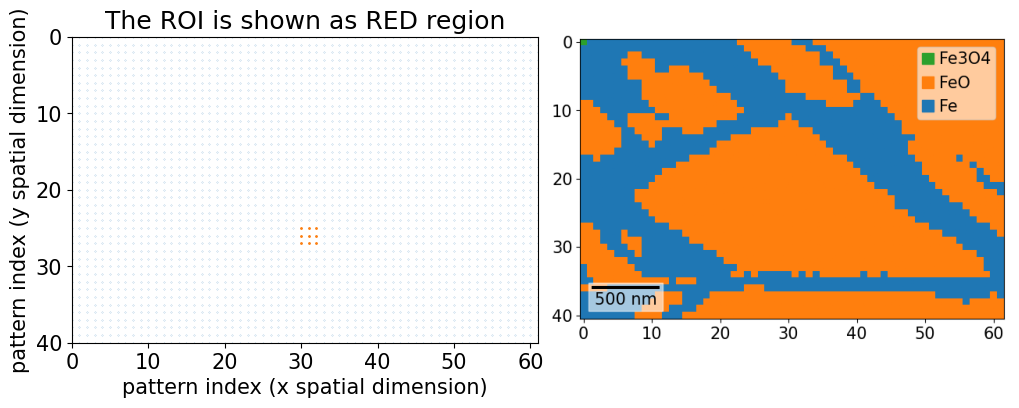

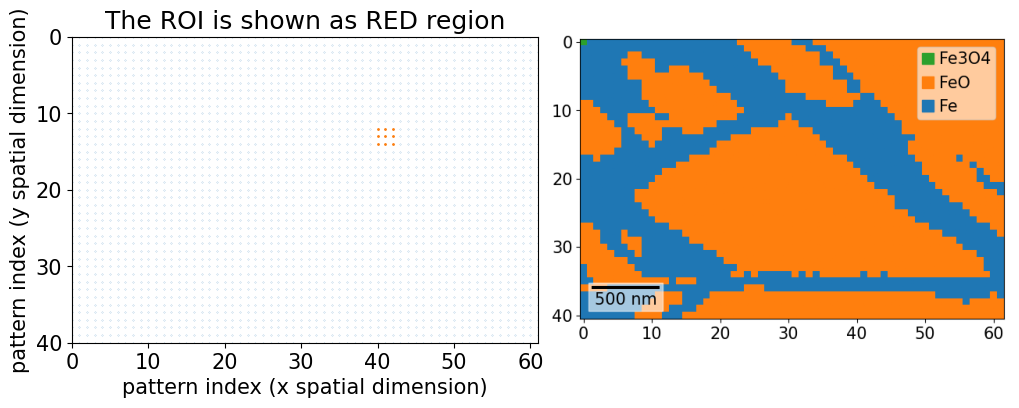

In [22]:
# set components
x_range_1 = (30,32)
y_range_1 = (25,27)
R1, ref1_pos = set_component(x_range_1, y_range_1, path, grid)


x_range_2 = (40,42)
y_range_2 = (12,14)
R2, ref2_pos = set_component(x_range_2, y_range_2, path, grid)

In [23]:
# run cNMF
weights,mse,r_square = run_cNMF(R6, optimize_results['components'][0])

[########################################] | 100% Completed | 117.49 ms


[########################################] | 100% Completed | 106.13 ms
[########################################] | 100% Completed | 109.59 ms
[########################################] | 100% Completed | 107.69 ms
[########################################] | 100% Completed | 104.66 ms
[########################################] | 100% Completed | 104.26 ms
[########################################] | 100% Completed | 107.21 ms
[########################################] | 100% Completed | 107.43 ms
[########################################] | 100% Completed | 104.05 ms
[########################################] | 100% Completed | 107.57 ms
[########################################] | 100% Completed | 106.07 ms
[########################################] | 100% Completed | 106.76 ms
[########################################] | 100% Completed | 109.15 ms
[########################################] | 100% Completed | 104.74 ms
[########################################] | 100% Completed | 10

In [24]:
anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

weights for reference 1 are: 
 {weight_ref1}
weights for reference 2 are: 
 {weight_ref2}


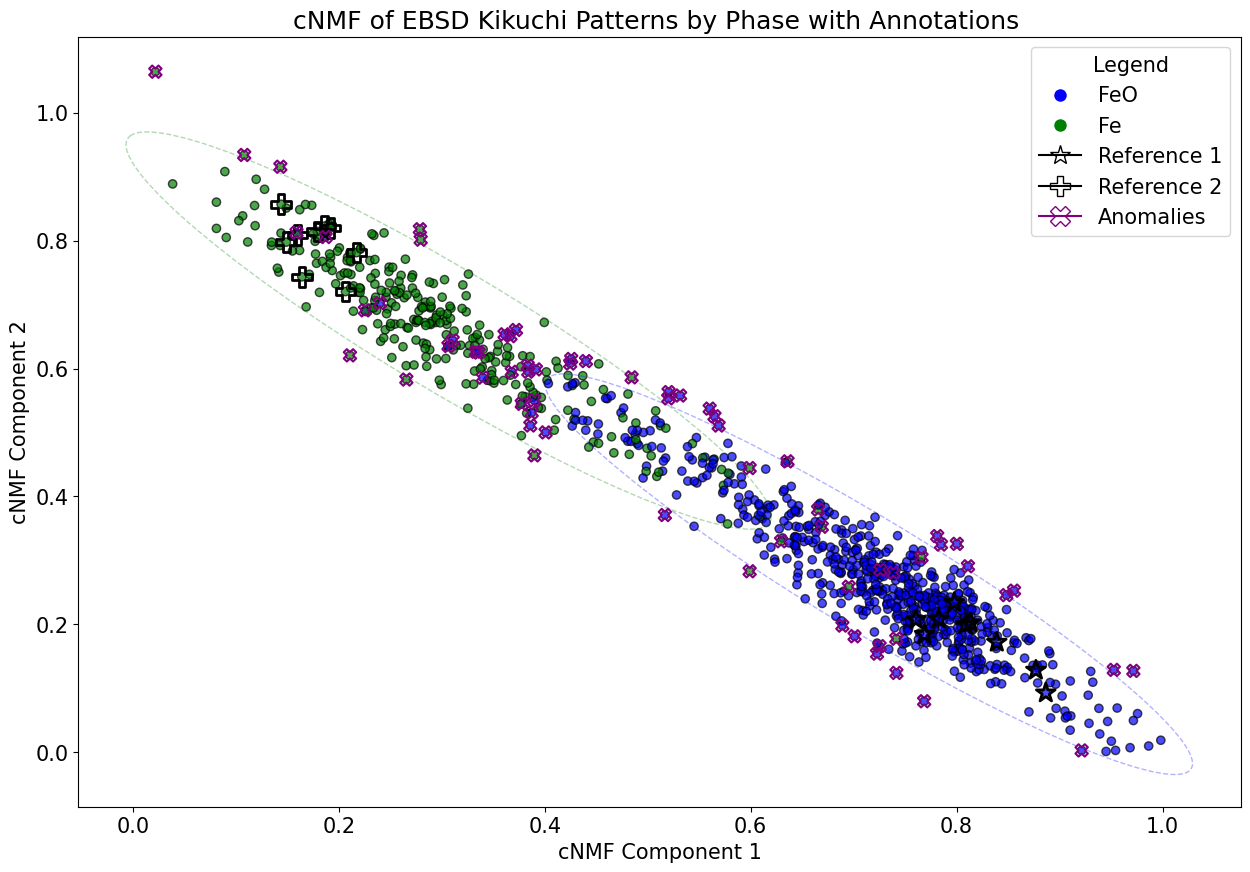

In [25]:
# _plot_cnmf(weights, coor_dict, loc)
_plot_cnmf(weights, coor_dict, loc, ref1_pos, ref2_pos, anomalies_scores)

(961, 1, 2)


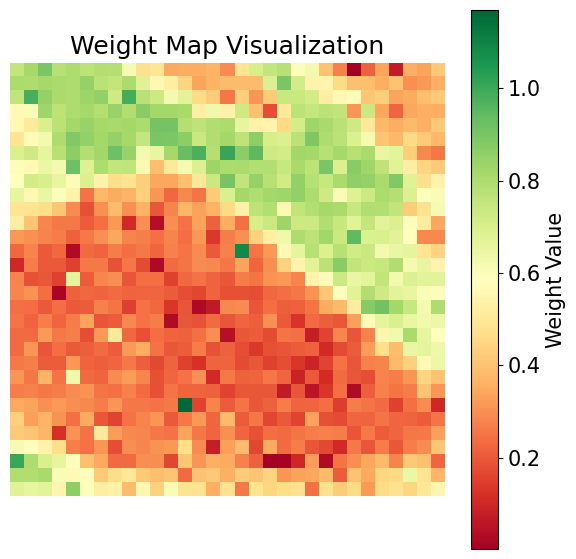

In [20]:
print(np.shape(weights))
weight_map = np.reshape(weights, (31, 31, 2)) 

im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value')  
plt.title("Weight Map Visualization")
plt.axis('off')  
plt.show()

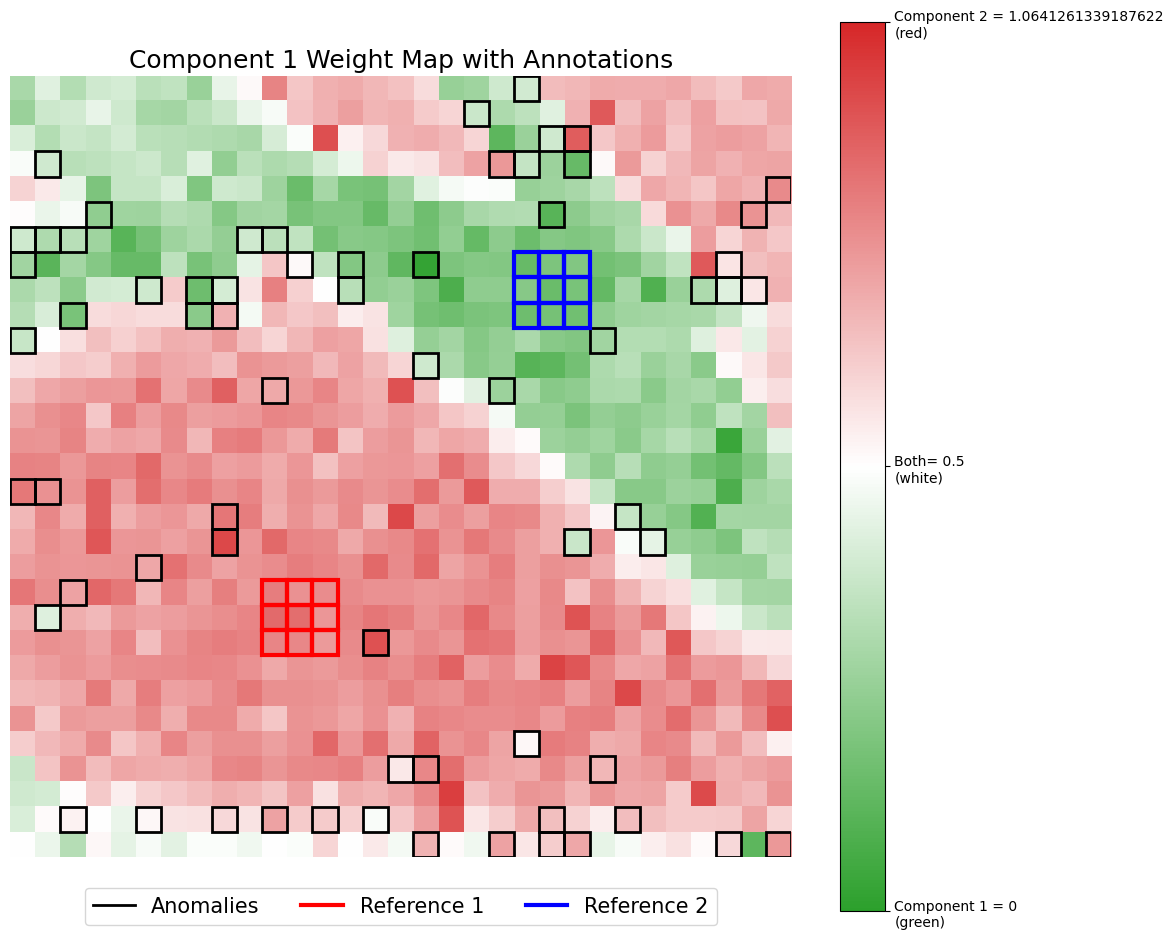

In [26]:
plot_weight_map_cnmf(weights, loc, anomalies_coords, ref1_pos, ref2_pos, 0)

### 1.3 EDS combined? （only content of elements）

### 1.3.1 cNMF

In [27]:
# stacked the pixel values with element values
eds_r1 = get_eds_average(x_range_1,y_range_1,s_edax)
eds_r2 = get_eds_average(x_range_2,y_range_2,s_edax)

eds_r1 = normalize_sum(eds_r1)
eds_r2 = normalize_sum(eds_r2)
eds = np.stack((eds_r1, eds_r2))

eds_mixed = np.hstack((optimize_results['components'][0],eds))

In [28]:
weights,mse,r_square = run_cNMF_mixeds(R6, eds_mixed, loc, s_edax)

[                                        ] | 0% Completed | 1.26 ms

[########################################] | 100% Completed | 109.43 ms
[########################################] | 100% Completed | 112.28 ms
[########################################] | 100% Completed | 105.02 ms
[########################################] | 100% Completed | 104.89 ms
[########################################] | 100% Completed | 104.15 ms
[########################################] | 100% Completed | 106.93 ms
[########################################] | 100% Completed | 106.64 ms
[########################################] | 100% Completed | 115.33 ms
[########################################] | 100% Completed | 106.13 ms
[########################################] | 100% Completed | 106.73 ms
[########################################] | 100% Completed | 106.59 ms
[########################################] | 100% Completed | 104.78 ms
[########################################] | 100% Completed | 106.45 ms
[########################################] | 100% Completed | 10

In [29]:
anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

weights for reference 1 are: 
 {weight_ref1}
weights for reference 2 are: 
 {weight_ref2}


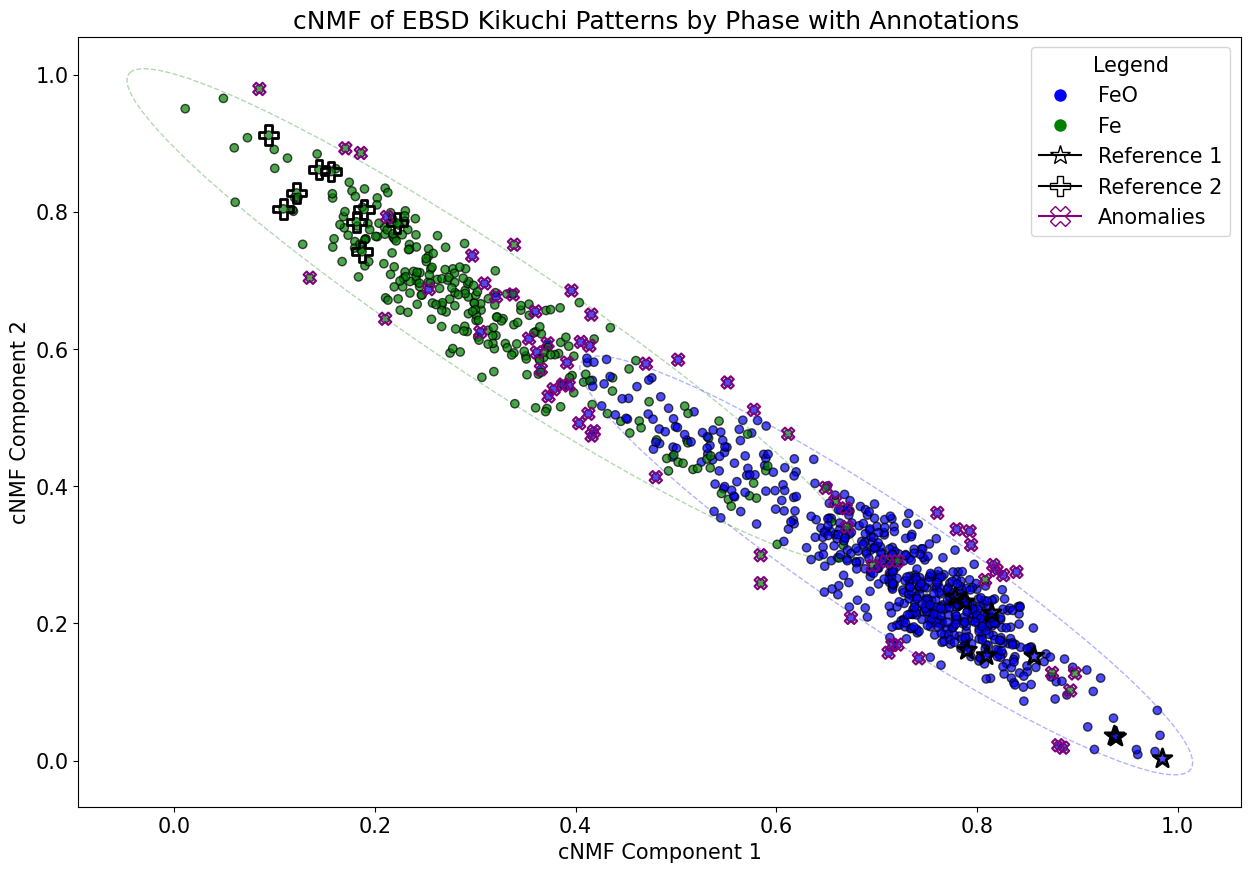

In [30]:
_plot_cnmf(weights, coor_dict, loc, ref1_pos, ref2_pos, anomalies_scores)

(961, 1, 2)


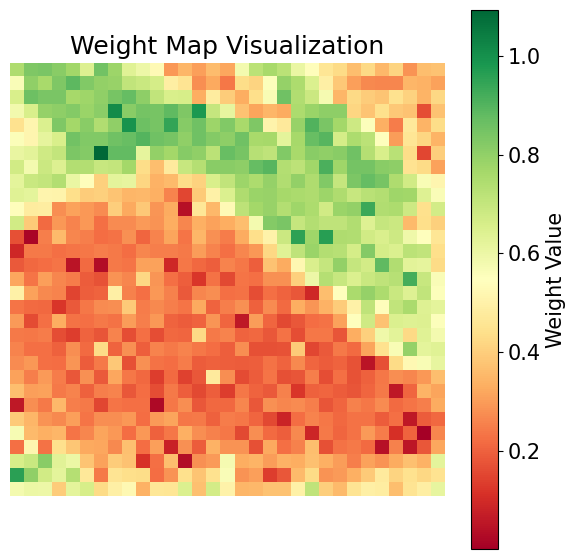

In [41]:
print(np.shape(weights))
weight_map = np.reshape(weights, (31, 31, 2)) 

im= plt.imshow(np.transpose(weight_map[:, :, 1]), cmap="RdYlGn")
plt.colorbar(im, label='Weight Value')  
plt.title("Weight Map Visualization")
plt.axis('off')  
plt.show()

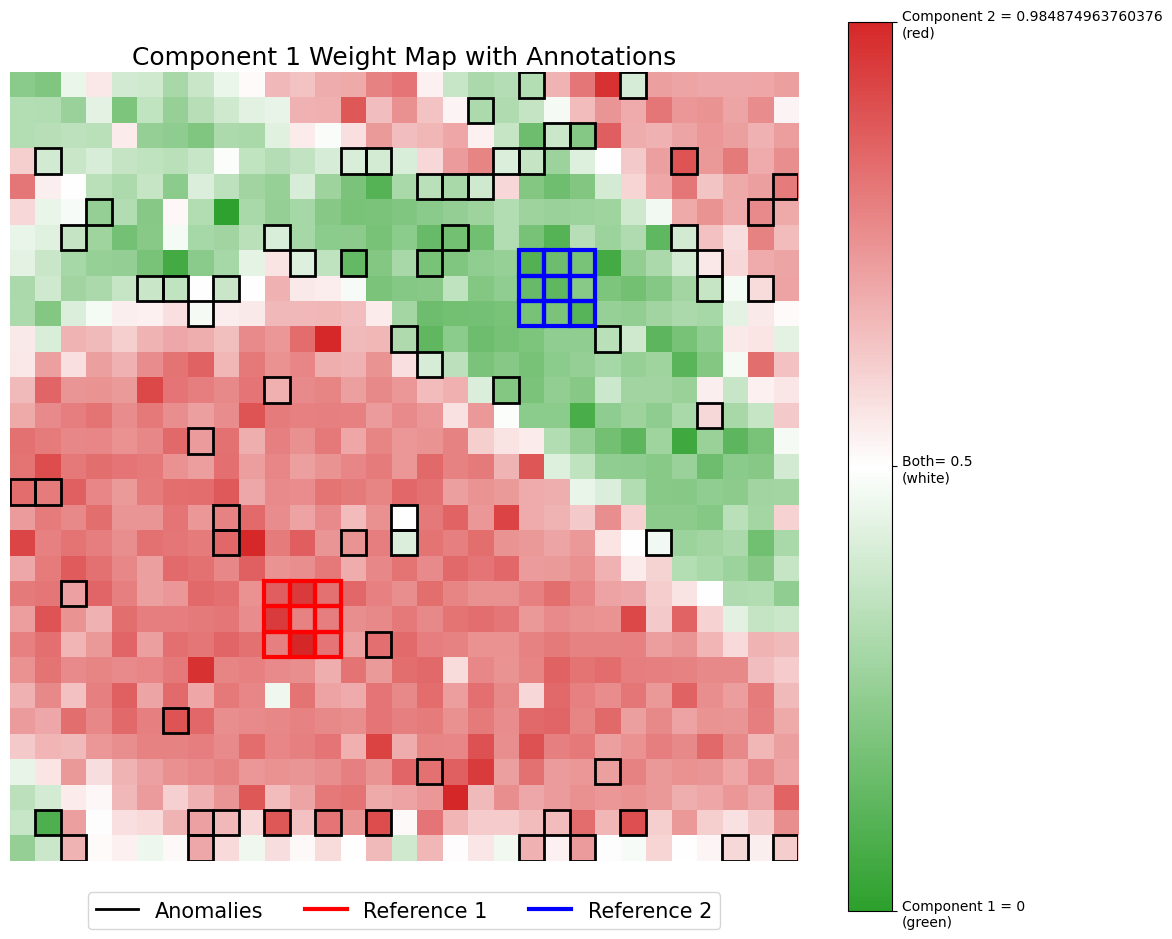

In [31]:
plot_weight_map_cnmf(weights, loc, anomalies_coords, ref1_pos, ref2_pos, 0)